# ポアソン混合分布推定(ギブスサンプリング)

In [2]:
# ライブラリ
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'merge, datasize=250')

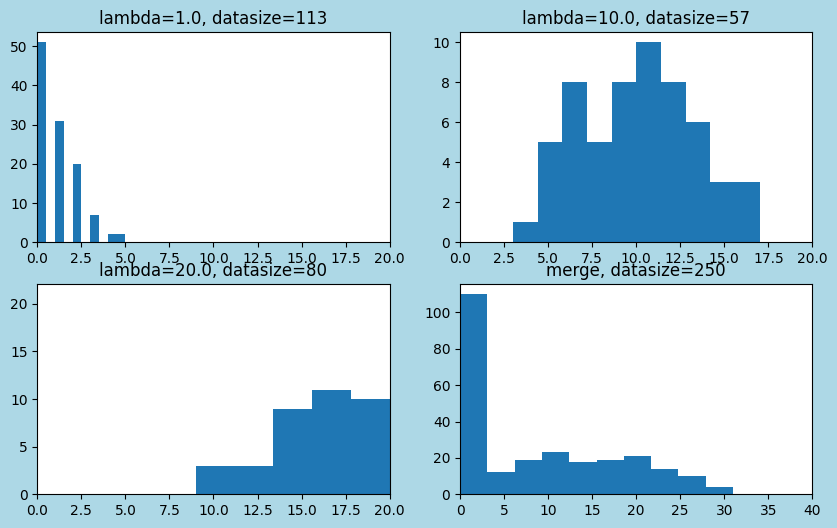

In [122]:
# 推定するポアソン混合分布を作る
K = 3
lambda_true = np.array([1.0, 10.0 ,20.0])
pi_truth_k  = np.array([0.5, 0.2, 0.3])
s_truth_nk = np.random.multinomial(n=1, pvals=pi_truth_k, size=250)
_, s_truth_n = np.where(s_truth_nk == 1)
fig = plt.figure(figsize = (10,6), facecolor='lightblue')
ax_list = [fig.add_subplot(2, 2, i+1) for i in range(K+1)] # グラフ。Ｋを変えるときは対応必須
values = np.random.poisson(lam=lambda_true[s_truth_n], size=250)
for k, ax, lam in zip(range(K), ax_list, lambda_true):
    # lam = np.random.uniform(1, 10) # ポアソン分布の平均を1から10でランダムにサンプリング
    # size = np.random.randint(10, 31) #10~30でランダムにデータサイズをサンプリング
    # poaisson_randoms = np.random.poisson(lam, size) # ポアソン分布をサンプリング
    _values = [values[i] for i, cls in enumerate(s_truth_n) if cls == k]
    ax.hist(_values)
    ax.set_xlim(0, 20)
    ax.set_title(f'lambda={round(lam,3)}, datasize={len(_values)}')
ax_list[-1].hist(values)  # 混合ポアソン分布
ax_list[-1].set_xlim(0, max(lambda_true)*2)
ax_list[-1].set_title(f'merge, datasize={len(values)}')

In [88]:
values

array([ 1.,  0.,  0.,  0.,  2.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,
        0.,  1.,  2.,  0.,  5.,  9.,  6.,  9., 16.,  9., 10., 11., 14.,
        9., 14., 19.,  9., 11., 12., 25., 18., 18., 17., 21., 23., 16.,
       18., 28., 27., 20., 22.])

## 混合モデルのデータ生成過程
1. それぞれのクラスタの混合比率 $\pi$ が事前分布 $p(\pi)$から生成される.
1. それぞれのクラスタ$k=1, \cdots, K$に対する観測モデルのパラメータ$\theta_k$が事前分布$p(\theta_k)$から生成される。
1. $n=1,\cdots,N$に関して、$x_n$に対するクラススタの割り当て$s_n$が比率$\pi$によってえらばれる。
1. $n=1,\cdots,N$に関して、$s_n$によって選択された$k$番目の確率分布$p(x_n|\theta_k)$からデータ$x_n$が生成される。

N個のデータに関する同時分布は
$$
p(X, S, \Theta, \pi) \\
= p(X, S , \Theta | \pi)p(\pi) \\
= p(X, S| \Theta, \pi) p(\Theta | \pi)p(\pi) \\
= p(X| S, \Theta, \pi) p(S|\Theta, \pi) p(\Theta|\pi) p(\pi) \\
= p(X|S, \Theta)p(S|\pi)p(\Theta)p(\pi) \\
= (\Pi_N p(x_n|s_n, \Theta)p(s_n|\pi))(\Pi_k p(\theta_k))p(\pi)
$$
第5式は$X$と$\pi$, $S$と$\Theta$, $\Theta$と$\pi$ がそれぞれ独立だからである。
求めたいのは
$$
p(S, \Theta, \pi | X) = \frac{p(X, S, \Theta, \pi)}{p(X)}
$$
あるいは
$$
p(S|X) = \int p(S, \Theta, \pi | X) d\Theta d\pi
$$
だが、この事後分布の確率変数$S, \pi, \Theta$が複雑に絡み合っているので正規化項$p(X)$の計算が困難。まじめにやろうとすると、計算量が膨大⇒近似手法が必要ギブスサンプリングや変分離論

## ギブスサンプリング
$z_1^{(i)}, z_2^{(i)}, z_3^{(i)} \sim p(z_1, z_2, z_3)$
とサンプリングすることが難しい場合

$$
z_1^{(i)} \sim p(z_1| z_2^{(i-1)}, z_3^{(i-1)}) \\
z_2^{(i)} \sim p(z_2| z_1^{(i)}, z_3^{(i-1)}) \\
z_3^{(i)} \sim p(z_3| z_1^{(i)}, z_2^{(i)})
$$
とサンプリングすることを$ギブスサンプリング$とよぶ。このようなくり返し手続きで取り出された$z_k$はサンプルの数が十分に多い場合、真の事後分布からサンプルされたもの
とみなせることが保証されているらしい。

### ポアソン分布の場合
生成過程の逆から考えていく。$s_n$によって選択された$k$番目の確率分布は、ポアソン分布なので以下で与えられる。

$p(x_n|\lambda_k) = \text{Poi}(x_n|\lambda_k), k=1,\cdots, K$ 

また、$s_n$をサンプルするための分布としては、$\pi$をパラメータとした、カテゴリ分布を選べばよさそう。 

$p(s_n|\pi) = \text{Cat}(s_n|\pi)$

$s_n$をK次元のワンホットベクトルとすれば

$p(x_n|s_n, \lambda) = \Pi_k \text{Poi} (x_n | \lambda_k)^{s_{n, k}}$



#### ギブスサンプリングの戦略
事後分布$p(S, \lambda, \pi|X)$を求めたいが、そのままでは難しいのでギブスサンプリングを使ってみる。*混合分布では洗剤変数とパラメータを分けてサンプルすると十分に簡単な確率分布が得られることが知られているので*次のような戦略で各確率変数を取り出すことにする
$$
S \sim p(S | X, \lambda, \pi) \\
\lambda, \pi \sim p(\lambda, \pi | X,S)
$$
初めに、一つ目について考える。

$$
p(S | X, \lambda, \pi) \propto p(X,S,\lambda, \pi) \\
= p(X|S, \lambda)p(S|\pi)p(\lambda)p(\pi) \\
\propto p(X |S, \lambda)p(S|\pi) \\ 
= \Pi_{n=1}^N p(x_n|s_n, \lambda)p(s_n|\pi)
$$

両辺、対数をとると

$$
\ln p(S | X, \lambda, \pi) \\
= \ln \Pi_{n=1}^N p(x_n|s_n, \lambda)p(s_n|\pi) \\
= \sum_n \sum_k \ln \text{Poi} (x_n | \lambda_k)^{s_{n, k}} + \sum_n \text{Cat}(s_n|\pi) \\
= \sum_n \sum_k s_{n, k} \ln \frac{\lambda_k^{x_n} e^{-\lambda_k}}{x_n!} + \sum_n \sum_k s_{n,k} \ln \pi_k \\
= \sum_n \sum_k s_{n,k}( x_n \ln \lambda_k - \lambda_k + \ln \pi_k - \ln x_n!) \\
= \sum_n \sum_k s_{n,k}( x_n \ln \lambda_k - \lambda_k + \ln \pi_k) + const \\
$$

ここで、$\sum_k s_{n,k} = 1$で、$\eta'_{n,k} = exp( x_n \ln \lambda_k - \lambda_k + \ln \pi_k), \eta_{n,k} = \frac{\eta'_{n,k}}{\sum_k \eta'_{n,k}}$とすれば
右辺は、$s_n$に関するカテゴリ分布に対数を取ったものとみなせる。（定数分無視すれば..）
$$
s_n \sim \text{Cat}(s_n|\eta_k)
$$

次に、二つ目の式を考える。一つ目と同様に,

$$
p(\lambda, \pi | X,S) \propto p(X, S, \lambda, \pi) = p(X|S, \lambda)p(S|\pi)p(\lambda)p(\pi)
$$
ここで、$\lambda, \pi$が独立なのでそれぞれ別にサンプルできるようになる.まず、$\lambda$について考える.

$$
\ln p(X|S, \lambda)p(\lambda) = \ln \Pi_n \text{Poi} (x_n | \lambda_k)^{s_{n, k}} \text{Gam}(\lambda_k|a, b) \\
=  \sum_n \sum_k s_{n,k}( x_n \ln \lambda_k - \lambda_k) + \sum_k  (a-1) \ln \lambda_k  - b\lambda_k + const \\
$$

$$
=  \sum_k ( (\sum_{n} s_{n,k}x_n + a -1)\ln \lambda_k - (\sum_n s_{n,k} + b)\lambda_k)  + const
$$

となり、$\lambda$はk個の独立なガンマ分布$\text{Gam}(\lambda_k|a', b')$に従う。
ここで、
$$
a' = \sum_{n} s_{n,k} x_n + a \\
b' = \sum_n s_{n,k} + b
$$

次に、$\pi$について考えると,

$$
\ln p(S|\pi)p(\pi) = \ln \Pi_n \text{Cat}(s_n | \pi) \text{Dir}(\pi|\alpha) \\
= \sum_n \sum_k s_{n,k} \ln \pi_k  + \sum_k (\alpha_k -1) \ln \pi_k \\
= \sum_k (\sum_n s_{n,k} + \alpha_k -1) \ln \pi_k
$$

よって、$\pi$は以下のディリクレ分布でサンプルできる。
$$
\pi \sim \text{Dir}(\pi| \alpha')
$$
ここで、$\alpha' = (\sum_n s_{n,k} + \alpha_k) $

よって、以下のアルゴリズムで事後分布を推定できる。

```
パラメータのサンプル$\lambda, \pi$に初期値を設定

for i = 1, ・・・, 最大回数 do

    for n = 1, ・・・, N do

        $s_n \sim \text{Cat}(s_n|\eta_k)$

    end for

    for k = 1, ・・・, K do

        $\lambda \sim \text{Gam}(\lambda_k|a', b')$

    end for

    $\pi \sim \text{Dir}(\pi| \alpha')$
    
end for
``````
        

In [124]:
# ハイパーパラメータ
a = 1.0 # λの事前分布ガンマ分布のパラメータ
b = 1.0 # λの事前分布ガンマ分布のパラメータ
alpha = np.repeat(2.0, K) # piの事前分布ディリクレ分布のパラメータ

# 初期値
lambda_ = np.random.gamma(a, b, K)
pi = np.random.dirichlet(alpha)
# ギブスサンプラーの回数
N = 1000
for _ in range(N):
    s_n = []
    cls2sum = {k:0 for k in range(K)}
    cls2count = {k:0 for k in range(K)}
    for v in values:
        mx = np.max(v * np.log(lambda_) - lambda_ + np.log(pi))
        eta = np.exp(v * np.log(lambda_) - lambda_ + np.log(pi) - mx) # 最後のmxはオーバーフロー対策。計算結果には影響しない 
        eta = eta / sum(eta)
        cls = np.random.multinomial(n=1, pvals = eta)
        cls = np.argmax(cls)
        s_n.append(cls)
        cls2sum[cls] += v
        cls2count[cls] += 1
    lambda_ = []
    for cls in range(K):
        a_prime = cls2sum[cls] + a
        b_prime = cls2count[cls] + b
        lambda_.append(np.random.gamma(a_prime, 1/b_prime))
    lambda_ = np.array(lambda_)
    
    alpha_prime = np.array([cls2count[k] + alpha[k] for k in range(K)])
    # alpha_prime = alpha_prime / sum(alpha_prime)
    pi = np.random.dirichlet(alpha_prime)
    print(pi, lambda_)
        

    



[0.10776202 0.72983045 0.16240753] [ 0.24191669 12.70044619  0.33994705]
[0.13459951 0.512765   0.35263549] [ 0.32420307 14.74663383  0.76157625]
[0.08593906 0.53932423 0.37473671] [ 0.11617698 15.09578901  0.99520647]
[0.10236737 0.58088956 0.31674307] [ 0.10373398 16.14945802  1.3037364 ]
[0.13490058 0.55225449 0.31284493] [ 0.03954283 16.18860647  1.68462322]
[0.17347425 0.523606   0.30291975] [ 0.03235487 16.38134134  1.85204813]
[0.13262957 0.52809092 0.33927952] [ 0.02250658 16.69486152  1.64405406]
[0.14095327 0.50499557 0.35405115] [ 0.05912754 16.44142066  1.80110034]
[0.15092108 0.54685886 0.30222007] [ 0.15211326 16.53242577  1.86025121]
[0.22423273 0.51999984 0.25576743] [ 0.18076981 16.02012936  2.01605861]
[0.18571132 0.49638884 0.31789984] [ 0.16083719 16.61308368  2.31340923]
[0.1729046  0.52075745 0.30633795] [ 0.18698948 16.74989836  2.60811191]
[0.19994287 0.5428317  0.25722543] [ 0.21508648 15.60975302  2.86754911]
[0.27144967 0.49507273 0.2334776 ] [ 0.32759976 16.